In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("CelebA-HQ-img-2000", {}, "./CelebAMask-HQ-2000-sample/instances_CelebA-HQ_masked_train.json", "./CelebAMask-HQ-2000-sample/CelebA-HQ-img-2000")


In [3]:
register_coco_instances("CelebA-HQ-img-2000-val", {}, "./CelebAMask-HQ-2000-sample/instances_CelebA-HQ_masked_val.json", "./CelebAMask-HQ-2000-sample/CelebA-HQ-img-2000-val")




In [4]:
fruits_nuts_metadata = MetadataCatalog.get("CelebA-HQ-img-2000")
dataset_dicts = DatasetCatalog.get("CelebA-HQ-img-2000")

[06/22 09:11:50 d2.data.datasets.coco]: Loaded 1800 images in COCO format from ./CelebAMask-HQ-2000-sample/instances_CelebA-HQ_masked_train.json


In [5]:
fruits_nuts_metadata_val = MetadataCatalog.get("CelebA-HQ-img-2000-val")
dataset_dicts_val = DatasetCatalog.get("CelebA-HQ-img-2000-val")

[06/22 09:11:51 d2.data.datasets.coco]: Loaded 200 images in COCO format from ./CelebAMask-HQ-2000-sample/instances_CelebA-HQ_masked_val.json


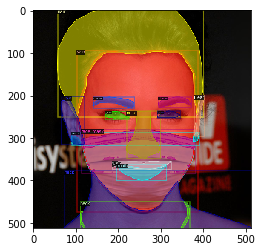

In [10]:
import random
import matplotlib.pyplot as plt

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    #cv2.imshow("",vis.get_image()[:, :, ::-1])

In [ ]:
import torch
torch.cuda.empty_cache()

In [7]:
from Models import LossEvalHook, MyTrainer


In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./Models/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("CelebA-HQ-img-2000",)
cfg.DATASETS.TEST = ("CelebA-HQ-img-2000-val",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 18  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer.MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/22 09:12:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/22 09:12:30 d2.data.datasets.coco]: Loaded 1800 images in COCO format from ./CelebAMask-HQ-2000-sample/instances_CelebA-HQ_masked_train.json
[06/22 09:12:30 d2.data.build]: Removed 0 images with no usable annotations. 1800 images left.
[06/22 09:12:30 d2.data.build]: Distribution of instances among all 18 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    skin    | 1800         | face_mask  | 891          |    hat     | 57           |
|   l_brow   | 1751         |   r_brow   | 1756         |   l_eye    | 1772         |
|   r_eye    | 1768         |    nose    | 1800         |   u_lip    | 1795         |
|   l_lip    | 1794         |   mouth    | 1097         |   l_ear    | 890          |
|   r_ear    | 795          |    neck    | 1884         |    hair    | 1781         |
|   cloth    | 903          |   ear_r    | 628          |   eye_g    | 50  

/opt/anaconda3/envs/image2stylegan/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/image2stylegan/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/image2stylegan/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/image

[06/22 09:12:32 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/22 09:12:33 d2.data.datasets.coco]: Loaded 200 images in COCO format from ./CelebAMask-HQ-2000-sample/instances_CelebA-HQ_masked_val.json
[06/22 09:12:33 d2.data.build]: Distribution of instances among all 18 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    skin    | 200          | face_mask  | 99           |    hat     | 6            |
|   l_brow   | 192          |   r_brow   | 192          |   l_eye    | 196          |
|   r_eye    | 196          |    nose    | 200          |   u_lip    | 199          |
|   l_lip    | 199          |   mouth    | 126          |   l_ear    | 99           |
|   r_ear    | 84           |    neck    | 205          |    h

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (19, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (19,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (72, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (72,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (18, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (18,) in the model!


[06/22 09:12:35 d2.engine.train_loop]: Starting training from iteration 0
[06/22 09:12:57 d2.utils.events]:  eta: 0:09:16  iter: 19  total_loss: 7.013  loss_cls: 3.112  loss_box_reg: 0.871  loss_mask: 0.691  loss_rpn_cls: 2.183  loss_rpn_loc: 0.178  time: 0.9429  data_time: 0.0604  lr: 0.000005  max_mem: 1864M
[06/22 09:13:16 d2.utils.events]:  eta: 0:08:52  iter: 39  total_loss: 6.077  loss_cls: 2.960  loss_box_reg: 0.891  loss_mask: 0.690  loss_rpn_cls: 1.349  loss_rpn_loc: 0.181  time: 0.9361  data_time: 0.0060  lr: 0.000010  max_mem: 1864M
[06/22 09:13:34 d2.utils.events]:  eta: 0:08:23  iter: 59  total_loss: 4.991  loss_cls: 2.715  loss_box_reg: 0.907  loss_mask: 0.689  loss_rpn_cls: 0.560  loss_rpn_loc: 0.166  time: 0.9352  data_time: 0.0069  lr: 0.000015  max_mem: 1864M
[06/22 09:13:54 d2.utils.events]:  eta: 0:08:17  iter: 79  total_loss: 4.309  loss_cls: 2.348  loss_box_reg: 0.904  loss_mask: 0.687  loss_rpn_cls: 0.250  loss_rpn_loc: 0.155  time: 0.9512  data_time: 0.0066  lr:

[06/22 09:22:58 d2.evaluation.evaluator]: Inference done 46/200. 0.3440 s / img. ETA=0:01:59
[06/22 09:23:03 d2.evaluation.evaluator]: Inference done 53/200. 0.3437 s / img. ETA=0:01:54
[06/22 09:23:09 d2.evaluation.evaluator]: Inference done 60/200. 0.3436 s / img. ETA=0:01:48
[06/22 09:23:14 d2.evaluation.evaluator]: Inference done 67/200. 0.3435 s / img. ETA=0:01:43
[06/22 09:23:19 d2.evaluation.evaluator]: Inference done 74/200. 0.3438 s / img. ETA=0:01:37
[06/22 09:23:25 d2.evaluation.evaluator]: Inference done 81/200. 0.3436 s / img. ETA=0:01:32
[06/22 09:23:30 d2.evaluation.evaluator]: Inference done 88/200. 0.3438 s / img. ETA=0:01:26
[06/22 09:23:36 d2.evaluation.evaluator]: Inference done 95/200. 0.3436 s / img. ETA=0:01:21
[06/22 09:23:41 d2.evaluation.evaluator]: Inference done 102/200. 0.3434 s / img. ETA=0:01:15
[06/22 09:23:46 d2.evaluation.evaluator]: Inference done 109/200. 0.3432 s / img. ETA=0:01:10
[06/22 09:23:52 d2.evaluation.evaluator]: Inference done 116/200. 0.

In [ ]:

%load_ext tensorboard

In [ ]:
tensorboard --logdir=d:/data --host 0.0.0.0

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set the testing threshold for this model
cfg.DATASETS.TEST = ("CelebA-HQ-img-2000-val", )
predictor = DefaultPredictor(cfg)

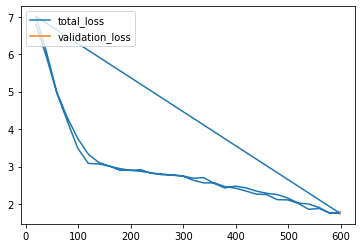

In [12]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()


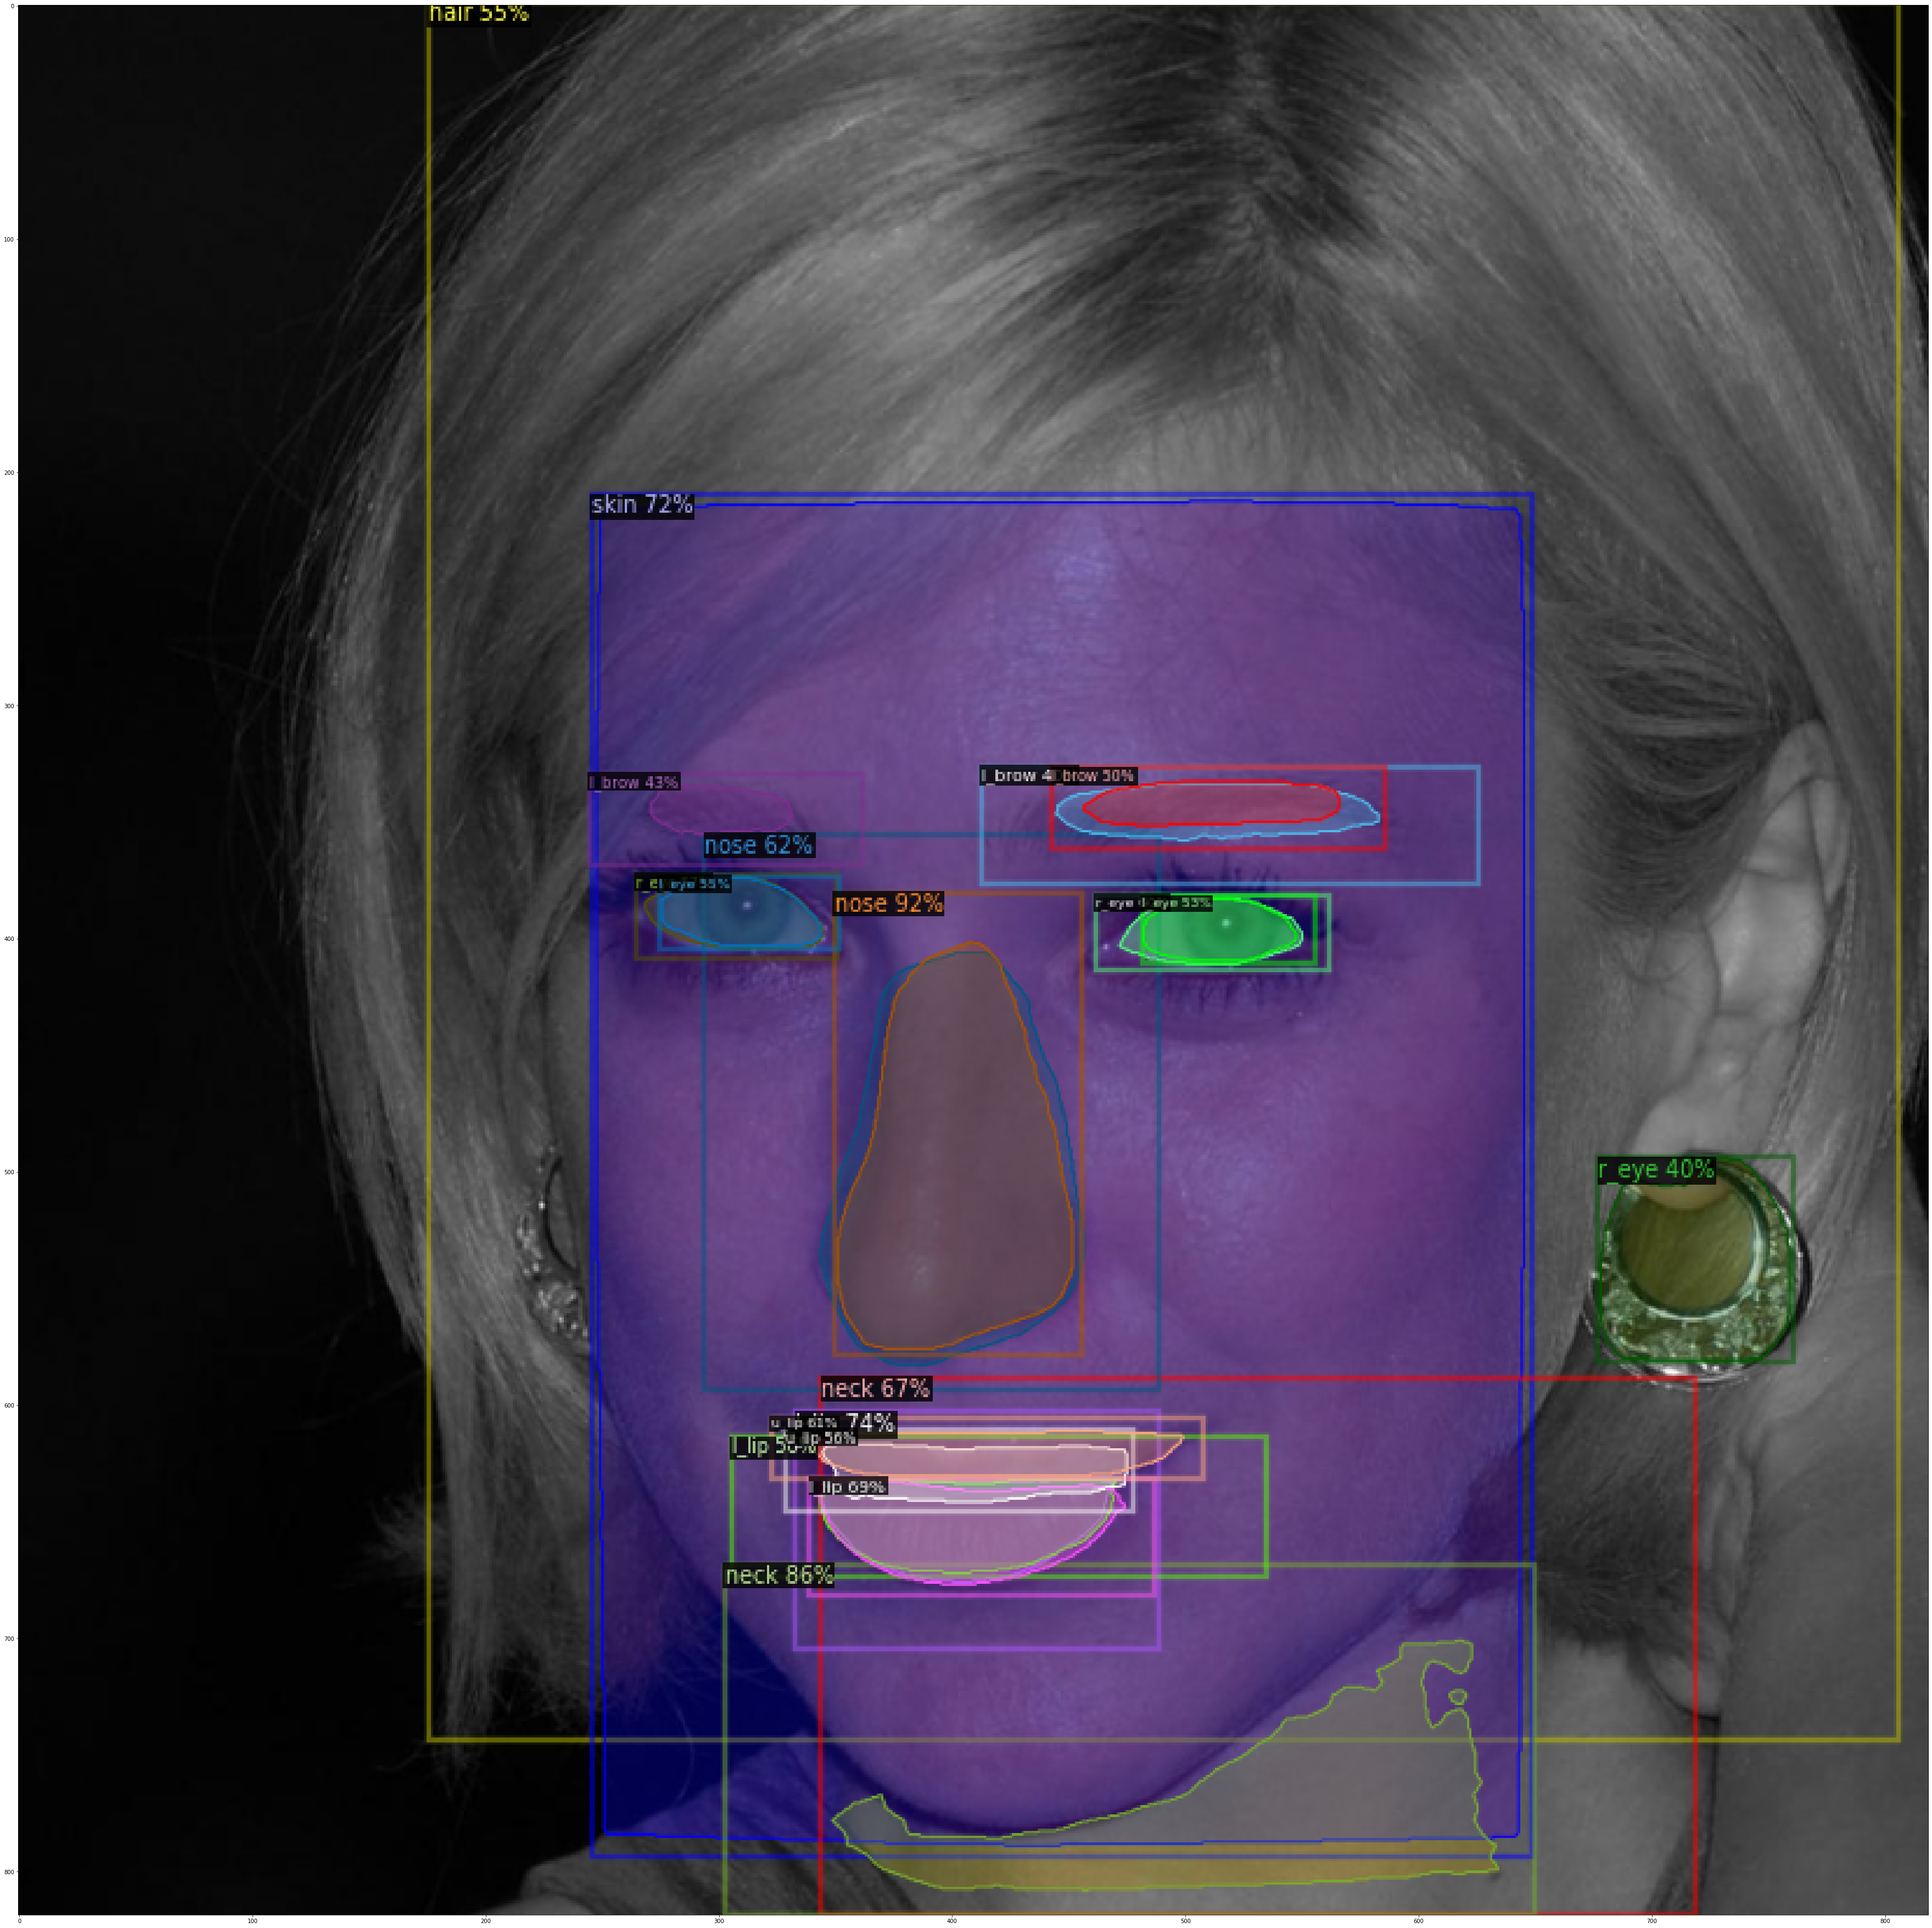

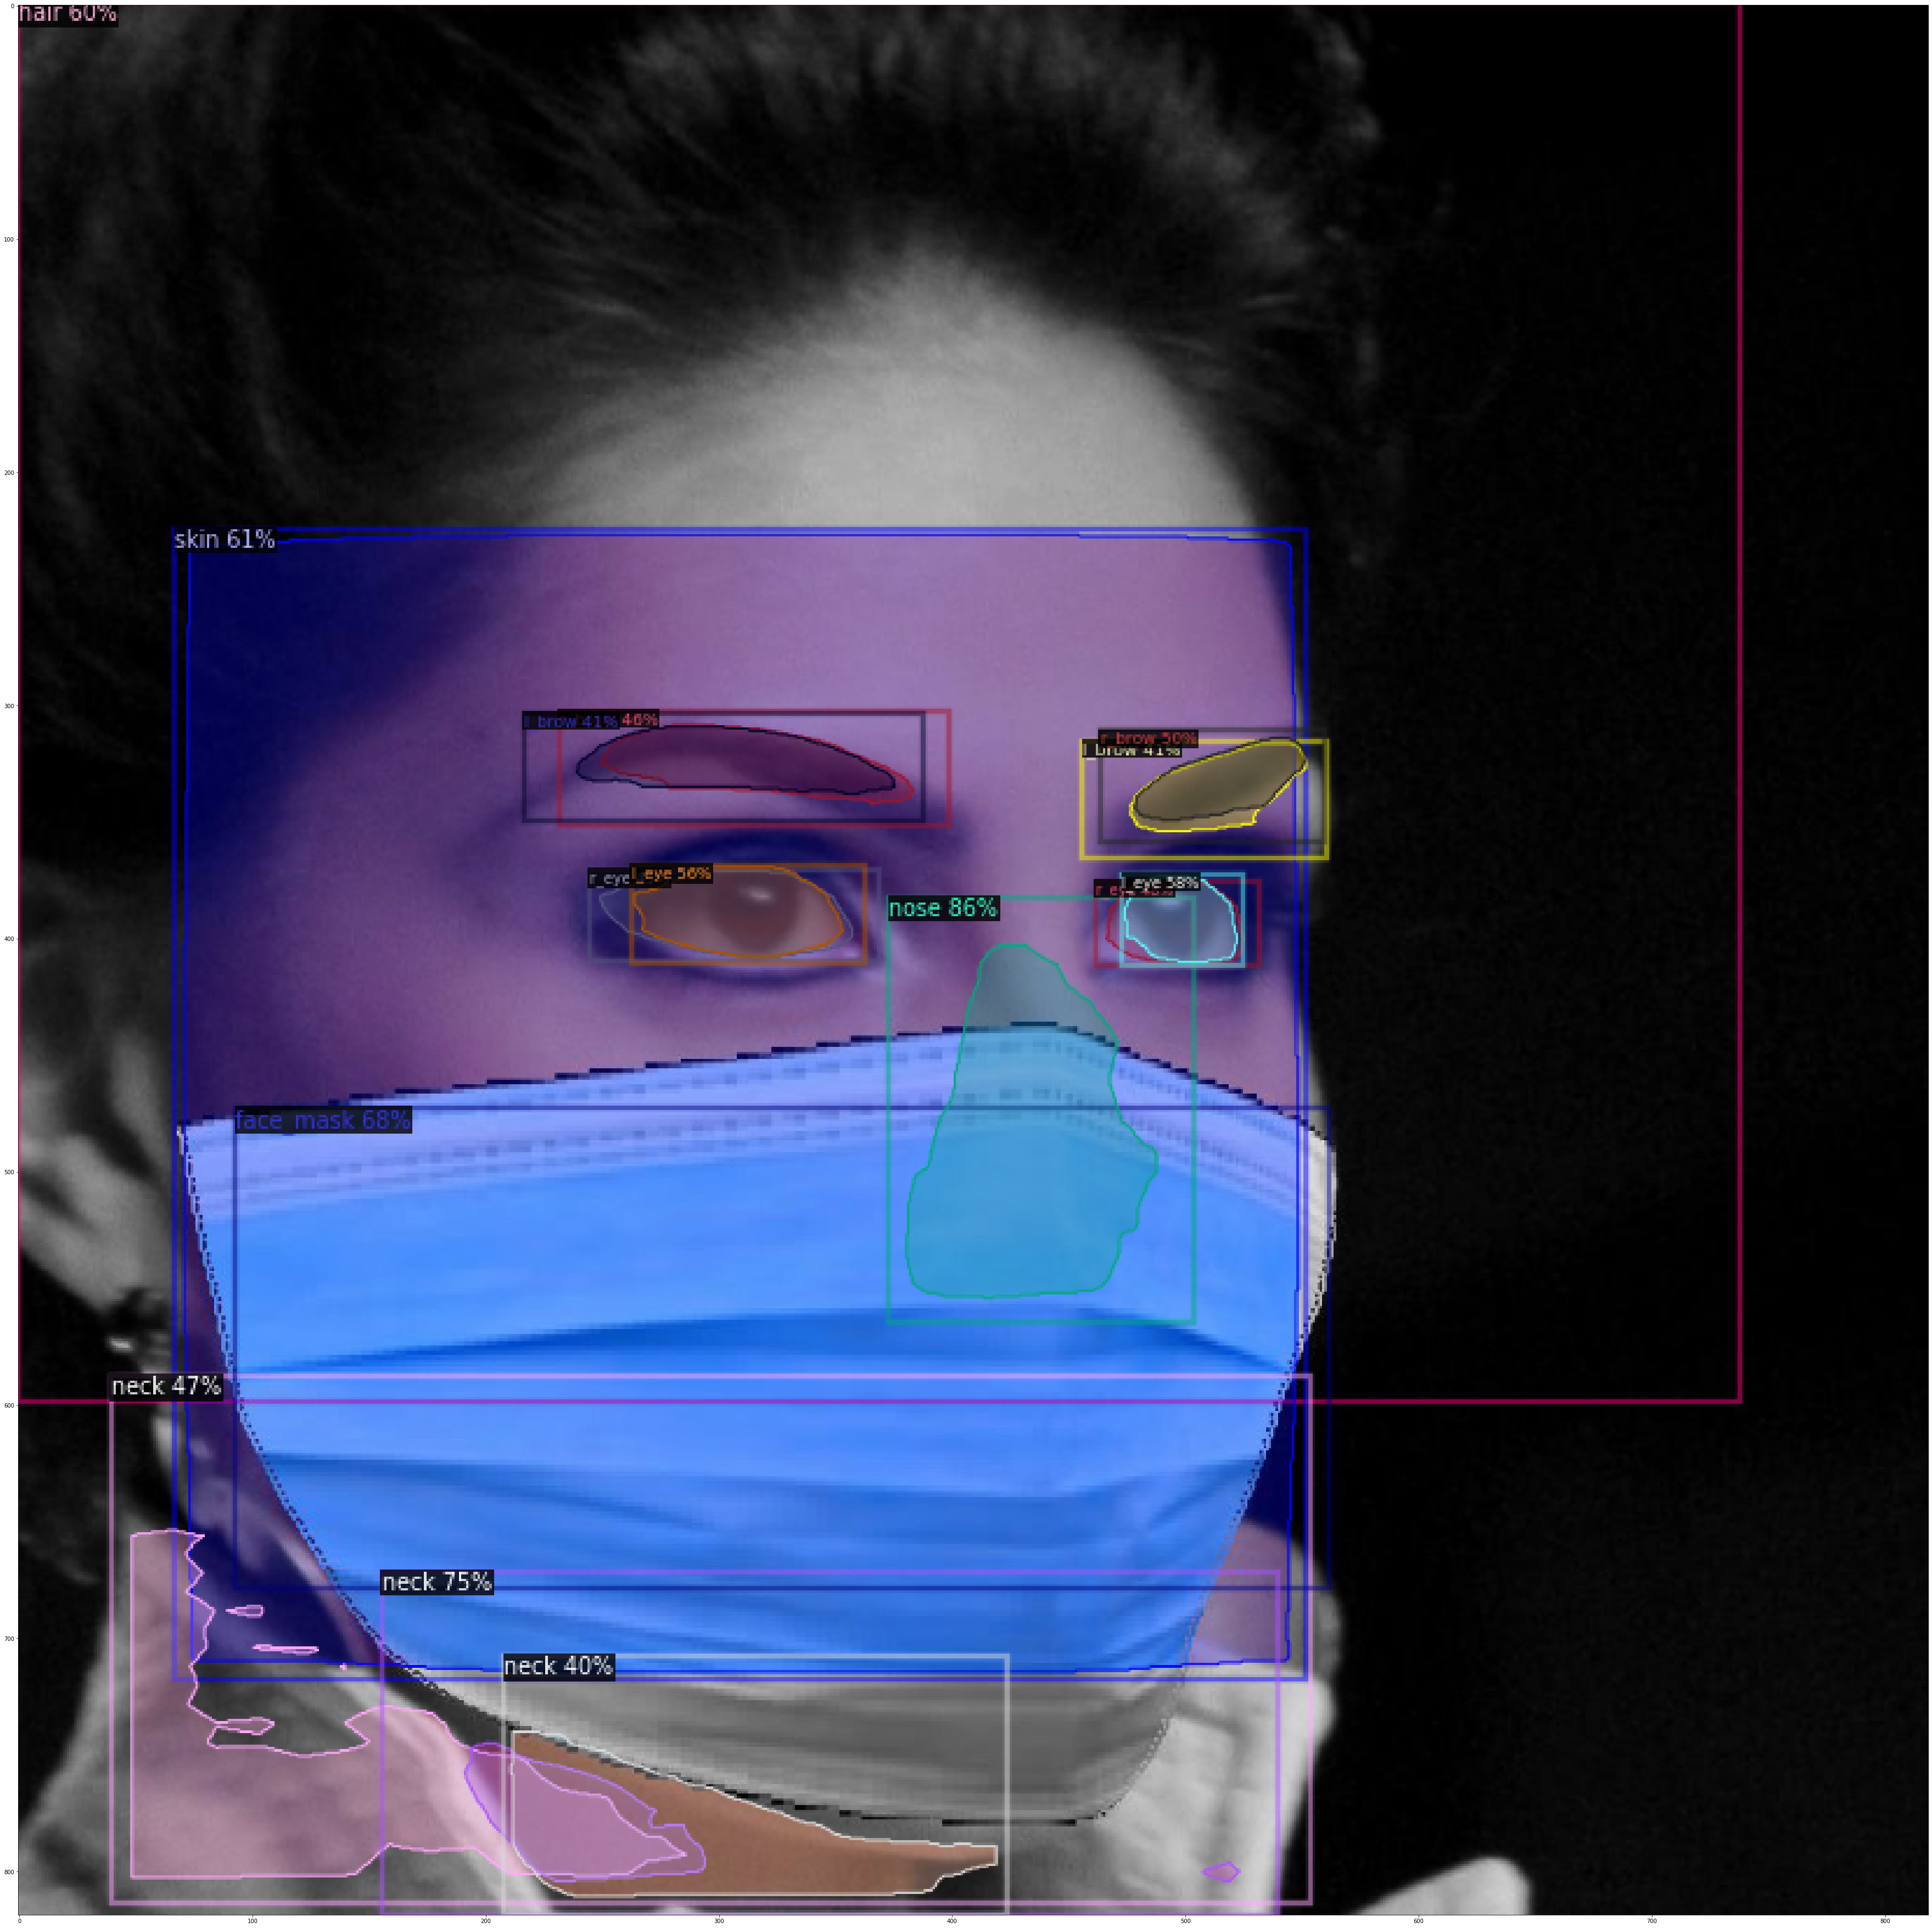

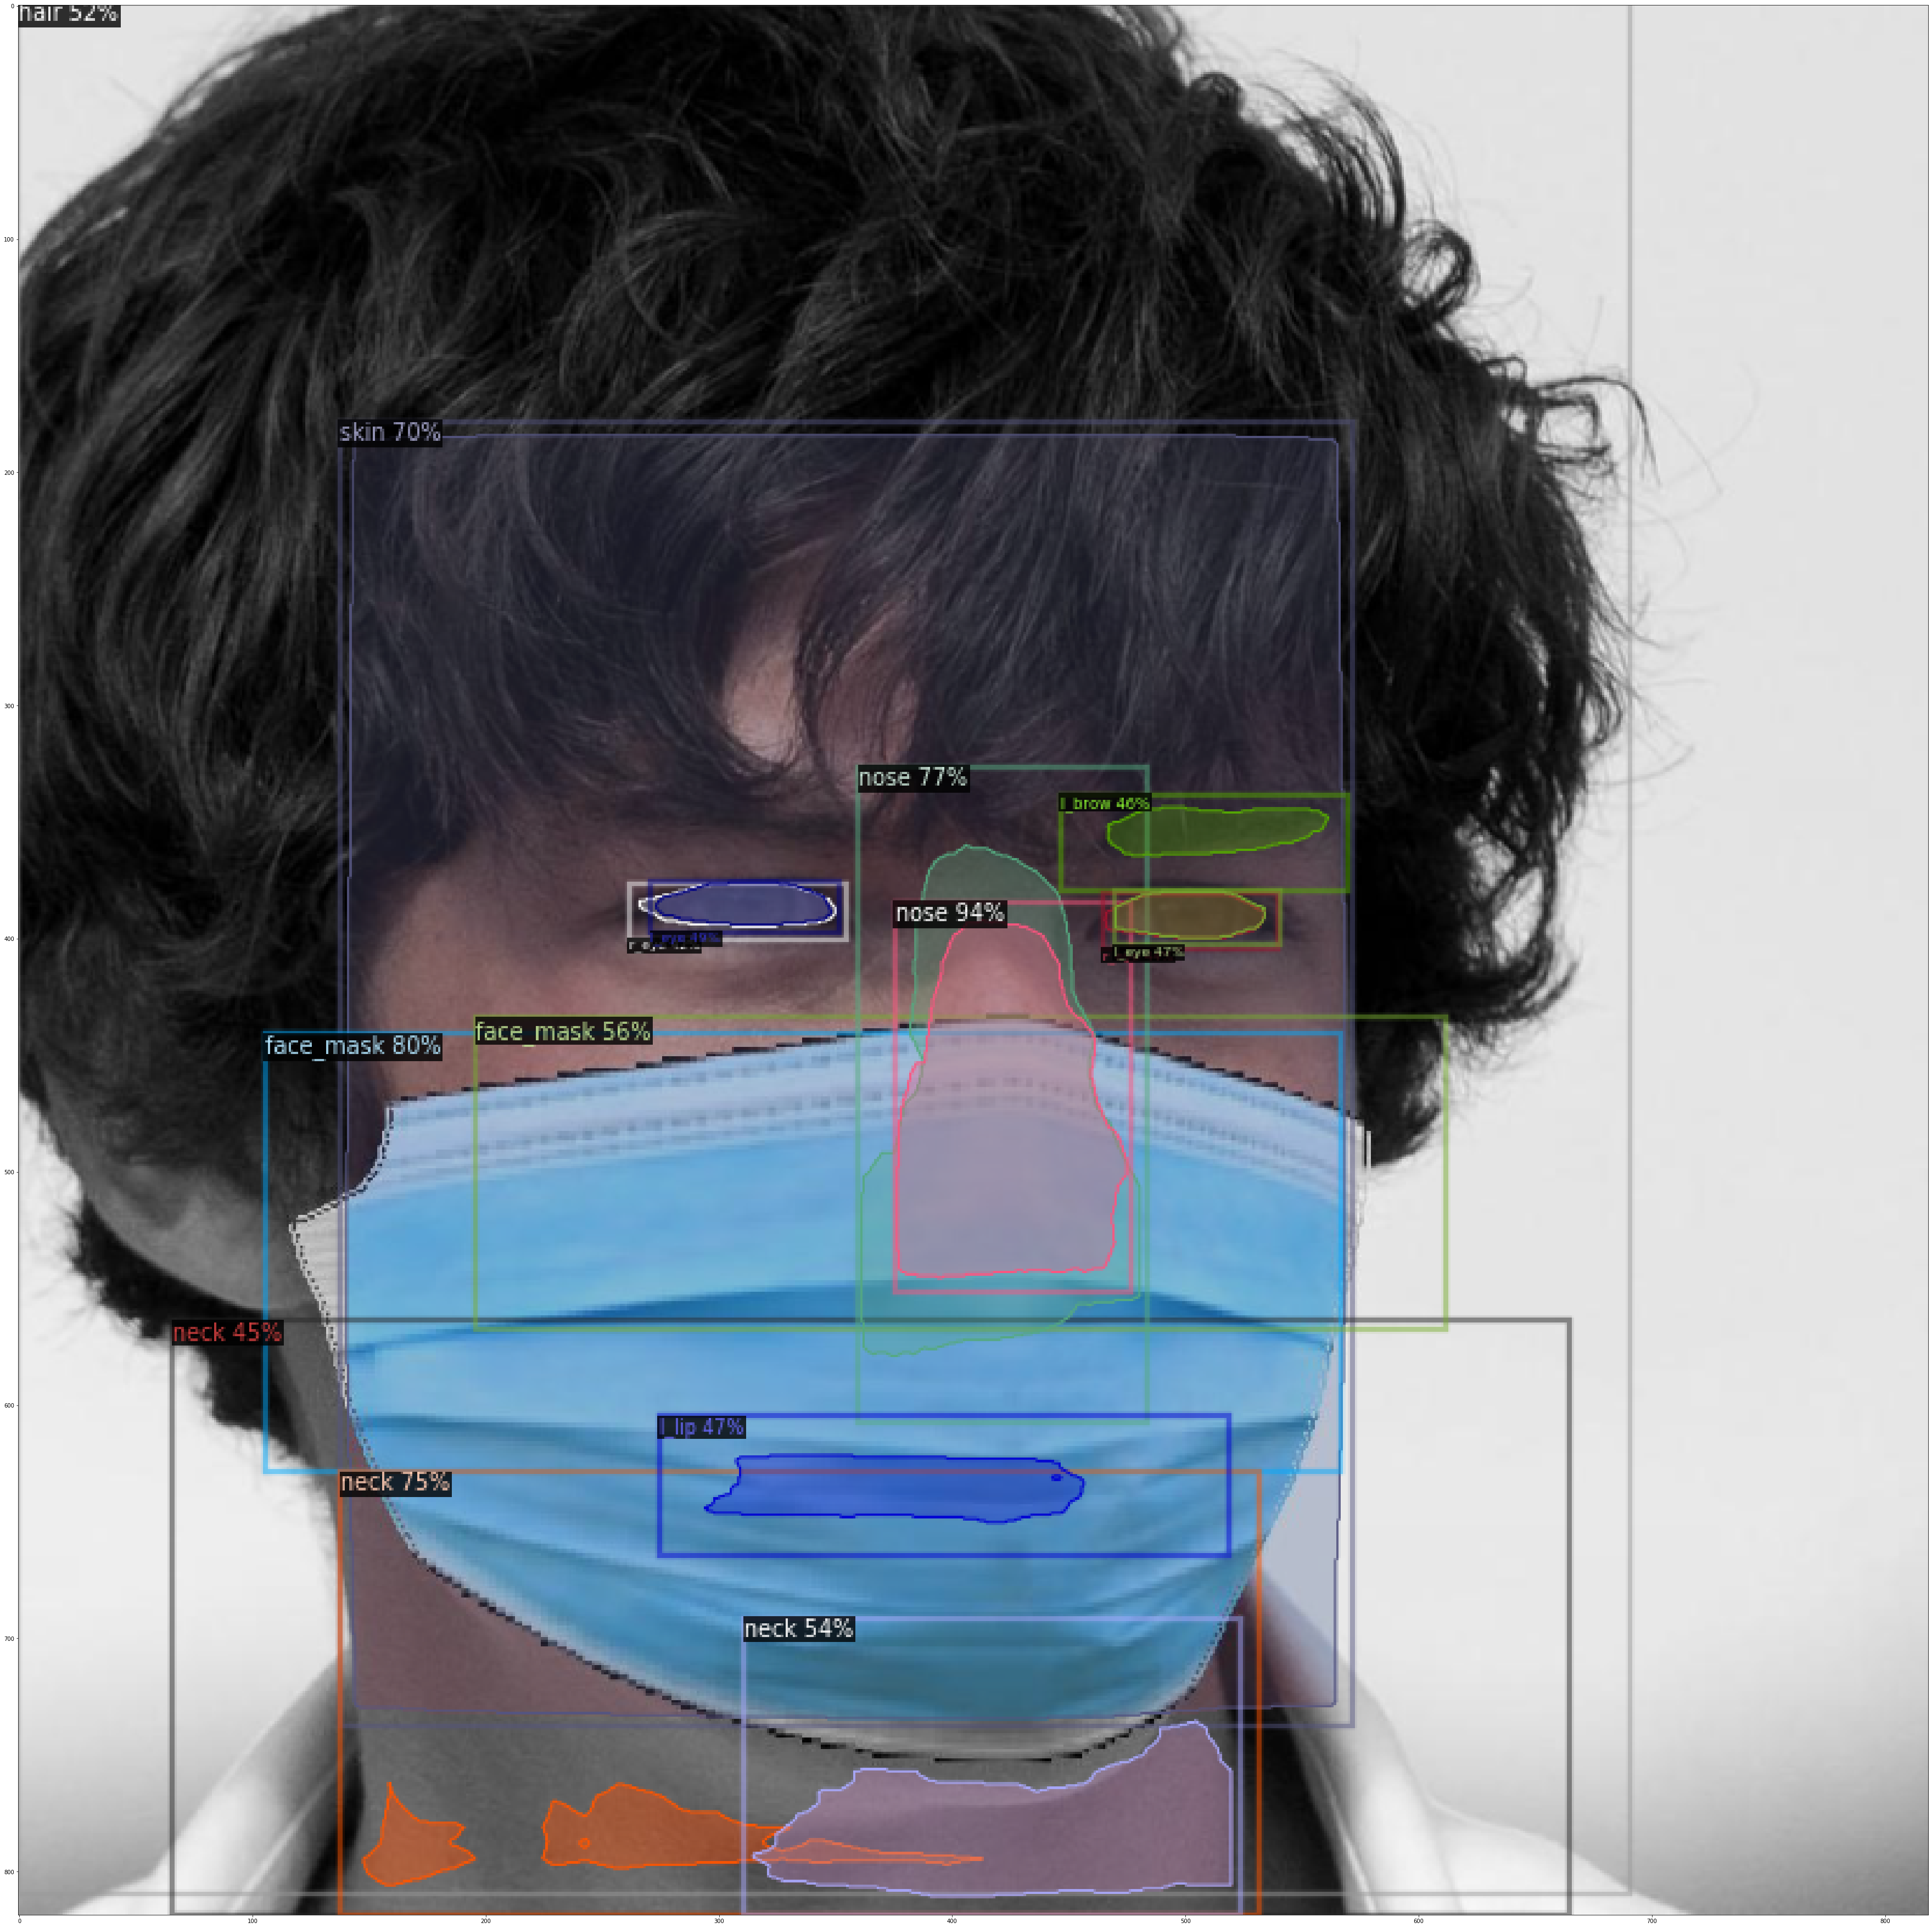

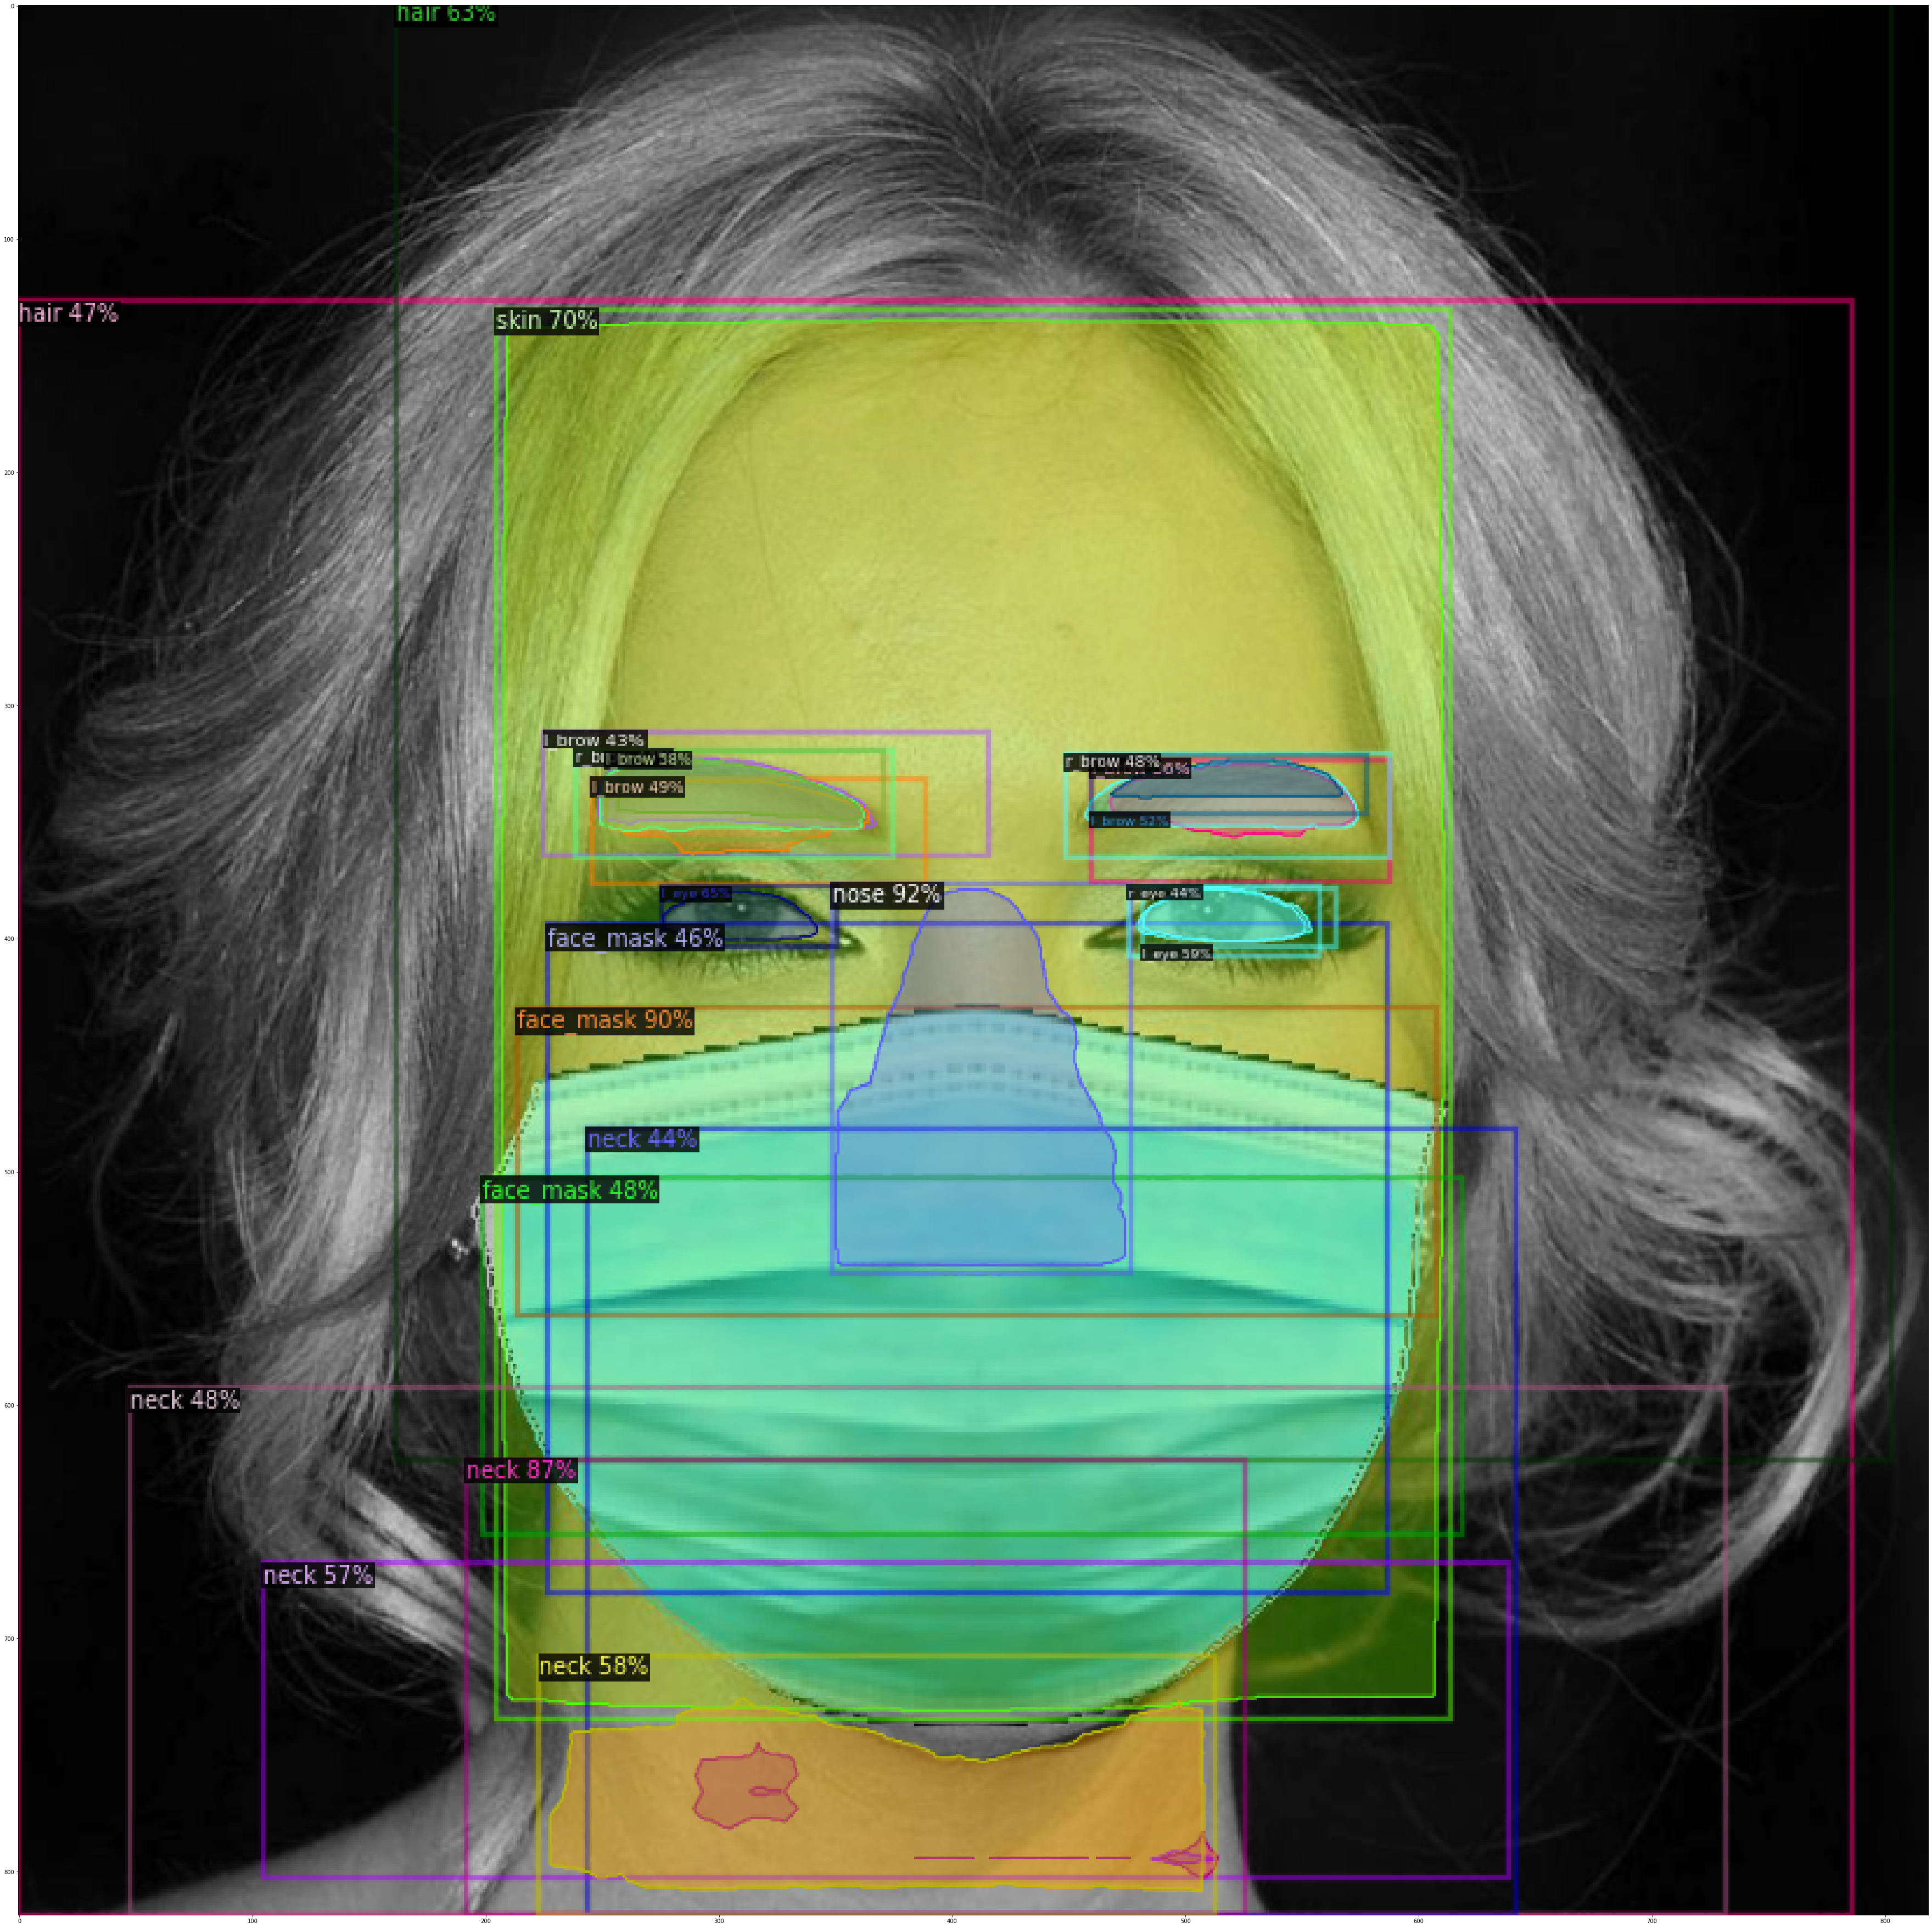

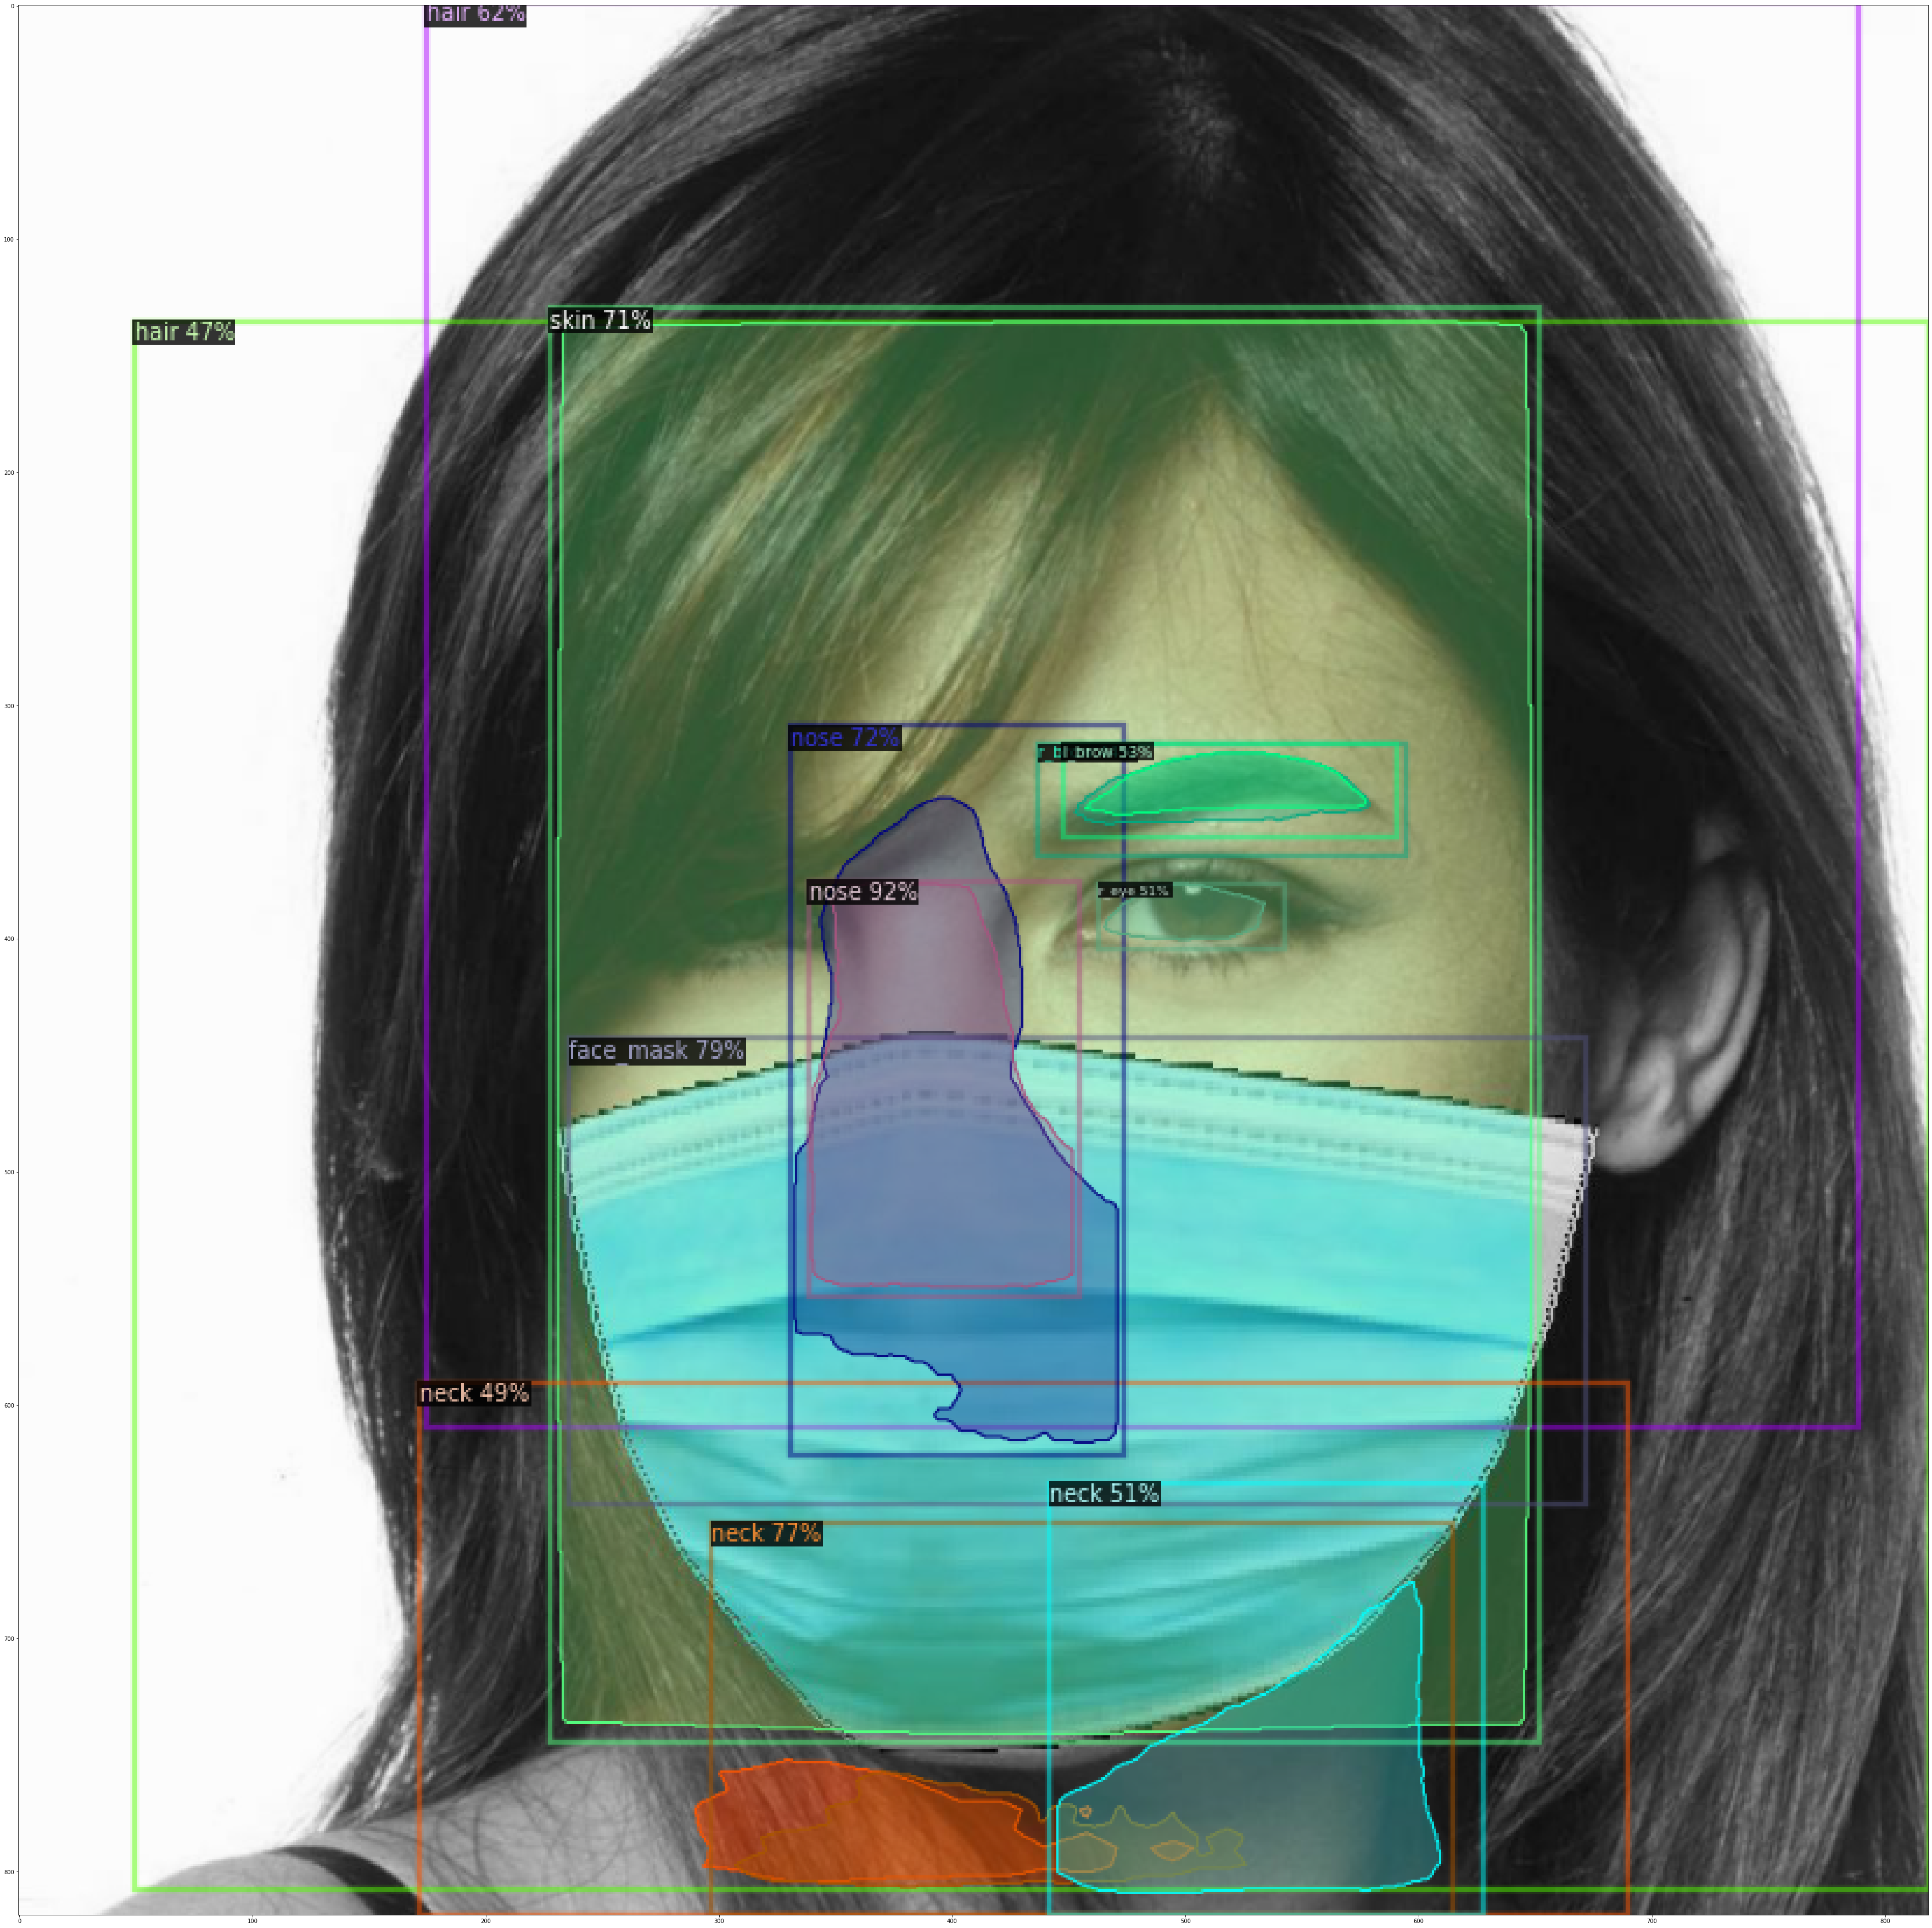

In [11]:
from detectron2.utils.visualizer import ColorMode
import random
for d in random.sample(dataset_dicts_val, 5):    
    
    im = cv2.imread(d["file_name"])
    
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata_val, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (64,64))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    #cv2_imshow(v.get_image()[:, :, ::-1])
   

In [ ]:
im = cv2.imread("./CelebAMask-HQ-2000-sample/ifim_with_mask.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
            metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (64,64))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
model_iter4000_lr0005_wf1_date2020_03_20__05_16_45
evaluator = COCOEvaluator("face_mask", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "face_mask")
inference_on_dataset(trainer.model, val_loader, evaluator)